In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mipt-bio-2025/fashion-mnist-testn/fmnist_test.csv
/kaggle/input/mipt-bio-2025/fashion-mnist-testn/sample_submission.csv
/kaggle/input/mipt-bio-2025/fashion-mnist-testn/fmnist_train.csv


In [ ]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-05-17 20:09:07.119415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747512547.307194      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747512547.362465      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Загрузка данных 
train_path = '/kaggle/input/mipt-bio-2025/fashion-mnist-testn/fmnist_train.csv'
test_path = '/kaggle/input/mipt-bio-2025/fashion-mnist-testn/fmnist_test.csv'
submission_path = '/kaggle/input/mipt-bio-2025/fashion-mnist-testn/sample_submission.csv'

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [ ]:
# Проверка на пустные значения и вывод размера трейна и теста
result = {
    "train_shape": train_df.shape,
    "test_shape": test_df.shape,
    "train_nan_count": train_df.isna().sum().sum(),
    "test_nan_count": test_df.isna().sum().sum()
}

result

{'train_shape': (17040, 786),
 'test_shape': (10000, 785),
 'train_nan_count': 424,
 'test_nan_count': 0}

В fmnist_train.csv оказались пропущенные значения — это значит, что у некоторых пикселей нет значения яркости, и они представлены как NaN. Keras (или любая другая нейросеть) не умеет с ними работать.

In [7]:
# Подготовка признаков
train_df = train_df.fillna(0)  # заполняем NaN нулям, так как это не вносит шум и не искажает данные
X = train_df.drop(columns=["label", "Id"]).values.reshape(-1, 28, 28, 1).astype("float32") / 255.0  # нормализация

y = to_categorical(train_df["label"].values, num_classes=10)

X_test = test_df.drop(columns=["Id"]).values.reshape(-1, 28, 28, 1).astype("float32") / 255.0  # нормализация

test_ids = test_df["Id"].values

In [8]:
# Разделение на обучение и валидацию 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
# Сверточная модель CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747512735.690566      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747512735.691356      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
# Компиляция
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Обучение
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=2
)

Epoch 1/20
120/120 - 1s - 5ms/step - accuracy: 0.8786 - loss: 0.3203 - val_accuracy: 0.8856 - val_loss: 0.3251
Epoch 2/20
120/120 - 1s - 5ms/step - accuracy: 0.8854 - loss: 0.3092 - val_accuracy: 0.8832 - val_loss: 0.3167
Epoch 3/20
120/120 - 1s - 4ms/step - accuracy: 0.8892 - loss: 0.2981 - val_accuracy: 0.8826 - val_loss: 0.3099
Epoch 4/20
120/120 - 1s - 4ms/step - accuracy: 0.8906 - loss: 0.2952 - val_accuracy: 0.8879 - val_loss: 0.3120
Epoch 5/20
120/120 - 1s - 4ms/step - accuracy: 0.8936 - loss: 0.2830 - val_accuracy: 0.8932 - val_loss: 0.2956
Epoch 6/20
120/120 - 1s - 4ms/step - accuracy: 0.8991 - loss: 0.2720 - val_accuracy: 0.8856 - val_loss: 0.2961
Epoch 7/20
120/120 - 1s - 4ms/step - accuracy: 0.8989 - loss: 0.2690 - val_accuracy: 0.8932 - val_loss: 0.2892
Epoch 8/20
120/120 - 1s - 4ms/step - accuracy: 0.9021 - loss: 0.2615 - val_accuracy: 0.8926 - val_loss: 0.2893
Epoch 9/20
120/120 - 1s - 4ms/step - accuracy: 0.9032 - loss: 0.2533 - val_accuracy: 0.8938 - val_loss: 0.2844
E

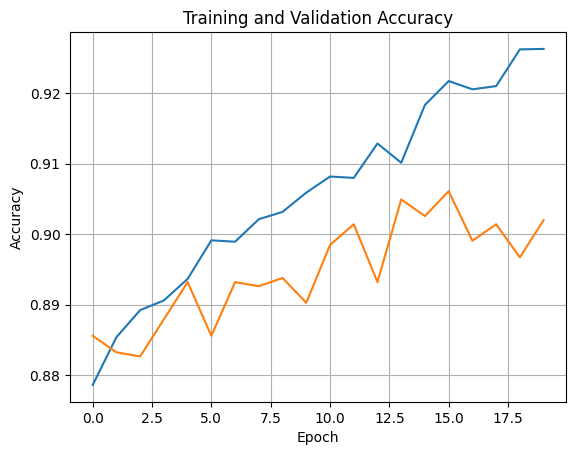

In [17]:
# Визуализация метрики
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

In [18]:
# Вывод метрик
print(f"Метрика train accuracy = {history.history['accuracy'][-1]:.4f}")
print(f"Метрика val accuracy = {history.history['val_accuracy'][-1]:.4f}")

Метрика train accuracy = 0.9263
Метрика val accuracy = 0.9020


In [19]:
# Предсказание
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

submission["label"] = y_pred_classes
submission.to_csv("/kaggle/working/submission.csv", index=False)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
